# COGS 108 - Final Project

### Group Members
- Aaron Lee
- Cassie Zhu (A13738990)
- Tina Chen
- Dillon Handal
- Emery Lin

### Overview
+ 3.5 pts for intro & background section
+ TODO: clear summary of what we did (3-4 sentences max)

### Intro
Anime is the Japanese word for animation. Outside of Japan, the term refers to a popular style of Japanese animation characterized by vibrant graphics and colorful characters. It has an appeal that bypasses borders and nationalities, captivating people of all ages across the globe.

### Research Question
How does an anime fan's age influence their level of engagement with the general anime community?

### Background & Prior Work
+ TODO: explanation of work done previously (include citation & links)

https://www.kaggle.com/azathoth42/myanimelist <- has links to other demographical analyses

### Hypothesis
Hypothesis: As anime fans age, they watch less anime and engage less with the community. 

Explanation: We believe our hypothesis is correct because older people have more obligations to their job, family, etc. Thus, older anime fans will have less free time to indulge in their hobby.

# Dataset

Name: MyAnimeList Dataset

Link to the dataset: https://www.kaggle.com/azathoth42/myanimelist

Number of observations: anime_filtered.csv, animelists_filtered.csv and users_filtered.csv collectively contain
+ 116,133 unique users with demographic data
+ 35,802,010 records in anime lists
+ 14,474 unique anime

The cleaned versions (anime_cleaned.csv, animelists_cleaned.csv, users_cleaned.csv) removed a negligible amount of observations.

Description: A cleaned kaggle dataset populated by information from MyAnimeList, one of the largest consolidations of anime titles and user ratings/info in the fandom.

# Data Analysis

### Setup

In [71]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from time import sleep
from IPython.display import clear_output

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [3]:
# import cleaned csvs
animeCleaned = pd.read_csv('myanimelist/anime_cleaned.csv')
usersCleaned = pd.read_csv('myanimelist/users_cleaned.csv')
#was taking forever to run so commented out for now
#animelistFiltered = pd.read_csv('myanimelist/animelists_cleaned.csv')

In [4]:
usersCleaned[:5]

,username,user_id,user_watching,user_completed,user_onhold,...,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,...,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,...,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,...,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,...,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,...,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


### Data Cleaning
+ 3.5pts
+ TODO: perform data cleaning or explain steps taken OR include explanation why data cleaning is unecessary (how did you determine the dataset was ready to go). Dataset should actually be clean and usable after the data cleaning steps are carried out

The kaggle set is pre-cleaned. We just need to check that the distribution of data is normal or at least if there is any bias, we are able to spot it out immediately. Some data may not be accurate so we would also need to prune and check for those.

### Data Visualization
+ 5.25pts
+ TODO: include at least 3 visualizations. All axes on plots should be clearly labeled. Types of all plots are appropriate given data displayed. Interpretation of each visualization included in text

Since we're interested in the age distribution, we can plot the age groups and total anime watched per age group to get an idea if we have a balanced dataset.

In [5]:
# add age column to usersFiltered data frame
now = pd.Timestamp('now')

# remove the two users who have odd birth dates
#usersCleaned = usersFiltered.drop([78772, 89578])

usersCleaned['birth_date'] = pd.to_datetime(usersCleaned['birth_date'], format='%Y-%m-%d')
usersCleaned['age'] = (now - usersCleaned['birth_date']).astype('<m8[Y]').astype(int)

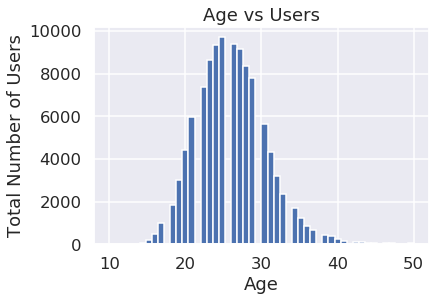

In [6]:
# plot histogram of age range
histogram = usersCleaned.hist(column="age", bins=50)
plt.title('Age vs Users')
plt.xlabel('Age')
plt.ylabel('Total Number of Users')
plt.show()

Given that our age range is mostly constricted around the twenties to forties, we can break our age group further into generational gaps to find a certain pattern that helps answer our research question.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


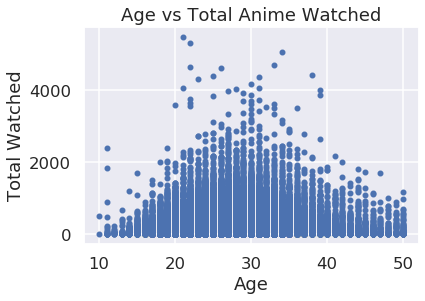

In [7]:
# plot age groups to total anime watching or completed
usersCleaned['total_watched'] = usersCleaned['user_watching'] + usersCleaned['user_completed']

plot = usersCleaned[['age', 'total_watched']].plot.scatter('age', 'total_watched')
plt.title('Age vs Total Anime Watched')
plt.xlabel('Age')
plt.ylabel('Total Watched')
plt.show()

In [9]:
#creates the data frame, adding in the age column 
df = pd.DataFrame(pd.read_csv('myanimelist/users_cleaned.csv'))
now = pd.Timestamp('now')


#df = df.drop([78772, 89578])
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%Y-%m-%d')
df['age'] = (now - df['birth_date']).astype('<m8[Y]').astype(int)


In [10]:
#cleans up the data, getting rid of any values that seem false
#for i, r in df.iterrows():
#   age = r['age']
#    if age > 80 or r['user_days_spent_watching'] > 3000:
#        df = df.drop(i)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


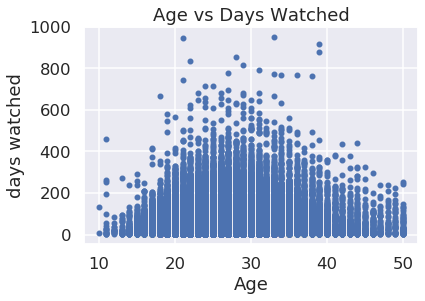

In [130]:
#scatter plot for age vs days watched
df['age'] = pd.to_numeric(df['age'])
df['user_days_spent_watching'] = pd.to_numeric(df['user_days_spent_watching'])
#scatter plot 
ax = df.plot( x = 'age',y = 'user_days_spent_watching',kind = 'scatter')
plt.ylabel('days watched')
plt.xlabel('Age')
plt.title('Age vs Days Watched')

plt.show()

In [25]:
#gets the data of average and total days watched for age groups
age10 = 0
age20 = 0
age30 = 0
age40 = 0
age50 = 0


age10C = 0
age20C = 0
age30C = 0
age40C = 0
age50C = 0


for i, r in df.iterrows():
    age = r['age']
    days_watched = r['user_days_spent_watching']
    if(age <= 10 & age >= 0):        
        age10 += days_watched
        age10C += 1
    if(age <= 20 & age >= 11):
        age20 += days_watched
        age20C += 1
    if(age <= 30 & age >= 21):
        age30 += days_watched
        age30C += 1
    if(age <= 40 & age >= 31):
        age40 += days_watched
        age40C += 1
    if(age <= 50 & age >= 41):
        age50 += days_watched
        age50C += 1


age10A = age10/age10C
age20A = age20/age20C
age30A = age30/age30C
age40A = age40/age40C
age50A = age50/age50C




In [49]:
#average days watched per age group
dataAverage = {'Age':['0 - 10','11 - 20','21 - 30','31 - 40',
               '41 - 50'], 
        'Average Days Watched': [age10A,age20A,age30A,age40A,age50A]} 
#total days watched per age group 
data = {'Age':['0 - 10','11 - 20','21 - 30','31 - 40',
               '41 - 50'], 
        'Total Days Watched In Thousands': [age10,age20,age30,age40,age50]} 
dfGroupedAverage = pd.DataFrame(dataAverage)
dfGrouped = pd.DataFrame(data)
dfGrouped['Total Days Watched In Thousands'] = dfGrouped['Total Days Watched In Thousands'].div(1000)

       Age  Total Days Watched In Thousands
0   0 - 10                             0.14
1  11 - 20                           259.63
2  21 - 30                          2496.85
3  31 - 40                           237.91
4  41 - 50                             4.87
       Age  Average Days Watched
0   0 - 10                 70.72
1  11 - 20                 53.07
2  21 - 30                 62.15
3  31 - 40                 69.18
4  41 - 50                 56.61


Text(0, 0.5, 'Total Days Watched in Thousands')

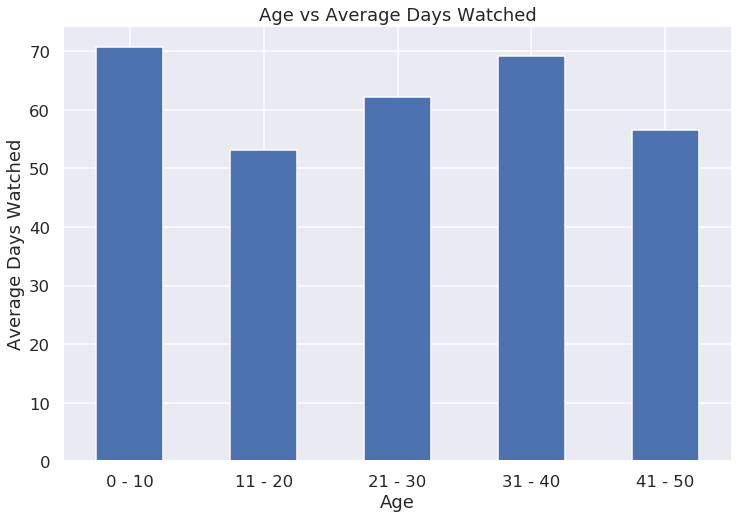

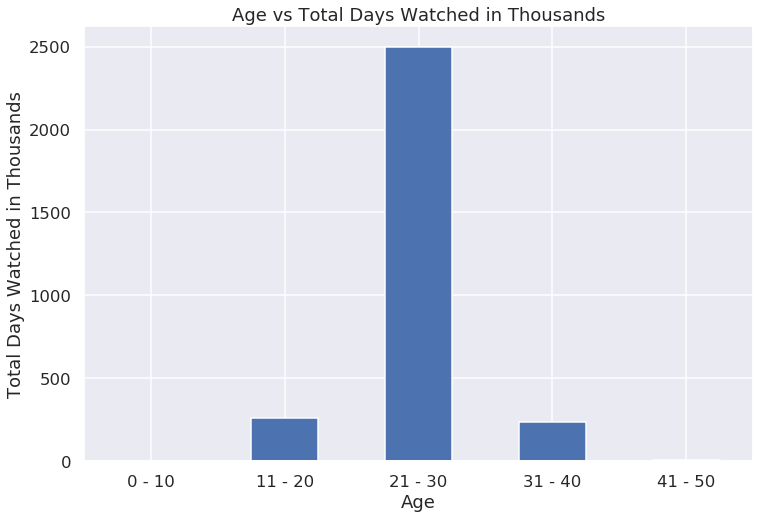

In [70]:
#graphs average and total days watched for age groups 
ax1 = dfGroupedAverage.plot.bar(x='Age', y='Average Days Watched', rot=0,figsize = (12,8),title = 'Age vs Average Days Watched',legend = False)
ax1.set_ylabel('Average Days Watched')
print(dfGrouped)
print(dfGroupedAverage)
ax2 = dfGrouped.plot.bar(x='Age', y='Total Days Watched In Thousands', rot=0,figsize = (12,8), title = 'Age vs Total Days Watched in Thousands',legend = False)
ax2.set_ylabel('Total Days Watched in Thousands')


In [74]:
#Linear Regression Shows that age does significantly predict days spent watching. This is shown by p-value of 0.
#don't rly think this is necessary, can be removed if you guys want. 
outcome_1, predictors_1 = patsy.dmatrices('user_days_spent_watching ~ age',df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                               OLS Regression Results                               
Dep. Variable:     user_days_spent_watching   R-squared:                       0.009
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     1003.
Date:                      Sat, 30 Nov 2019   Prob (F-statistic):          4.97e-219
Time:                              17:31:23   Log-Likelihood:            -5.9742e+05
No. Observations:                    108711   AIC:                         1.195e+06
Df Residuals:                        108709   BIC:                         1.195e+06
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [91]:
#seperates the data frame into older and younger groups <=30 and >30 
watched_young_data = df[df['age'] <= 30 ]['user_days_spent_watching'].values
watched_old_data = df[df['age'] > 30 ]['user_days_spent_watching'].values

In [94]:
#average of the two different groups 
avg_young = np.mean(watched_young_data)
avg_old = np.mean(watched_old_data)
total_young = np.sum(watched_young_data)
total_old = np.sum(watched_old_data)
print('Average days watched of people younger than 30 is \t {:2.2f} days'.format(avg_young))
print('Average days watched of people older than 30 is \t {:2.2f} days'.format(avg_old))
print('Total days watched of people younger than 30 is \t {:2.2f} days'.format(total_young))
print('Total days watched of people older than 30 is \t\t {:2.2f} days'.format(total_old))

Average days watched of people younger than 30 is 	 60.26 days
Average days watched of people older than 30 is 	 71.35 days
Total days watched of people younger than 30 is 	 5573999.32 days
Total days watched of people older than 30 is 		 1156719.74 days


In [127]:
#finds the weighted average of those older than 30 and those younger than 30.
w_avg_young = (avg_young * watched_young_data.size) / (watched_young_data.size + watched_old_data.size)
w_avg_old = (avg_old * watched_old_data.size) / (watched_old_data.size + watched_young_data.size)
print('Weighted average days watched of people younger than 30 is \t {:2.2f} days'.format(w_avg_young))
print('Weighted average days watched of people older than 30 is \t {:2.2f} days'.format(w_avg_old))

Weighted average days watched of people younger than 30 is 	 51.27 days
Weighted average days watched of people older than 30 is 	 10.64 days


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


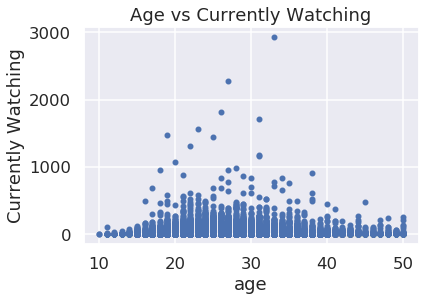

In [129]:
#graphs of age vs currently Watching
ax3 = df.plot( x = 'age',y = 'user_watching',kind = 'scatter')
plt.ylabel('Currently Watching')
plt.xlabel('Age')
plt.title('Age vs Currently Watching')

plt.show()

In [132]:
#gets the data of average and total currently watching for age groups
age10 = 0
age20 = 0
age30 = 0
age40 = 0
age50 = 0


age10C = 0
age20C = 0
age30C = 0
age40C = 0
age50C = 0


for i, r in df.iterrows():
    age = r['age']
    currently_watching = r['user_watching']
    if(age <= 10 & age >= 0):        
        age10 += currently_watching
        age10C += 1
    if(age <= 20 & age >= 11):
        age20 += currently_watching
        age20C += 1
    if(age <= 30 & age >= 21):
        age30 += currently_watching
        age30C += 1
    if(age <= 40 & age >= 31):
        age40 += currently_watching
        age40C += 1
    if(age <= 50 & age >= 41):
        age50 += currently_watching
        age50C += 1


age10A = age10/age10C
age20A = age20/age20C
age30A = age30/age30C
age40A = age40/age40C
age50A = age50/age50C



In [142]:
#average currently watching per age group
dataAverageWatching = {'Age':['0 - 10','11 - 20','21 - 30','31 - 40',
               '41 - 50'], 
        'Average Watching': [age10A,age20A,age30A,age40A,age50A]} 
#total currently watching per age group 
dataWatching = {'Age':['0 - 10','11 - 20','21 - 30','31 - 40',
               '41 - 50'], 
        'Total Watching': [age10,age20,age30,age40,age50]} 
dfAvg_watching = pd.DataFrame(dataAverageWatching)
dfWatching = pd.DataFrame(dataWatching)
dfWatching['Total Watching'] = dfWatching['Total Watching'].div(1000)

       Age  Average Watching
0   0 - 10              5.00
1  11 - 20             14.63
2  21 - 30             14.56
3  31 - 40             15.48
4  41 - 50             25.78
       Age  Total Watching
0   0 - 10            0.01
1  11 - 20           71.58
2  21 - 30          584.89
3  31 - 40           53.24
4  41 - 50            2.22


Text(0, 0.5, 'Total Currently Watching in Thousands')

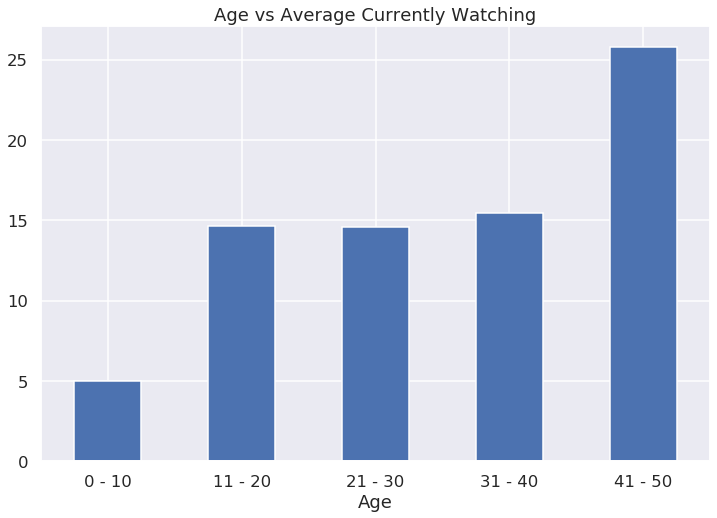

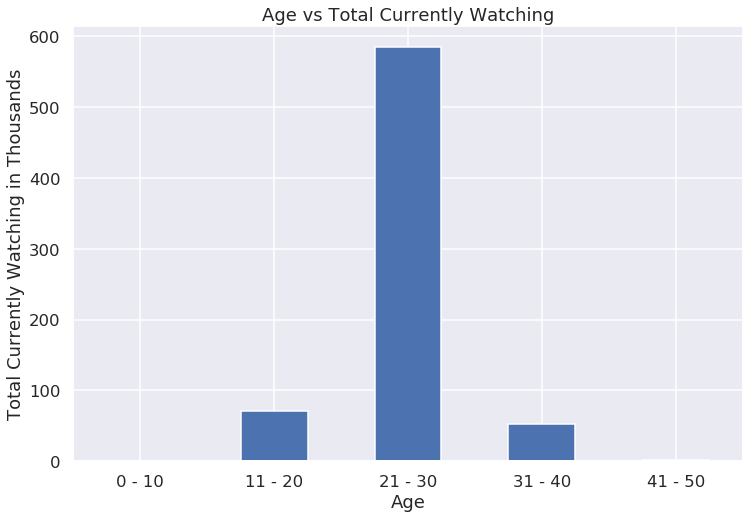

In [145]:
#graphs age vs currenlty watching
ax3 = dfAvg_watching.plot.bar(x='Age', y='Average Watching', rot=0,figsize = (12,8),title = 'Age vs Average Currently Watching',legend = False)
ax1.set_ylabel('Average Currently Watching')
print(dfAvg_watching)
print(dfWatching)
ax2 = dfWatching.plot.bar(x='Age', y='Total Watching', rot=0,figsize = (12,8), title = 'Age vs Total Currently Watching',legend = False)
ax2.set_ylabel('Total Currently Watching in Thousands')

In [146]:
#seperates the data frame into older and younger groups <=30 and >30 
watching_young_data = df[df['age'] <= 30 ]['user_watching'].values
watching_old_data = df[df['age'] > 30 ]['user_watching'].values

In [147]:
#finds average for those older than 30 and those younger than 30 
avg_young = np.mean(watching_young_data)
avg_old = np.mean(watching_old_data)
total_young = np.sum(watching_young_data)
total_old = np.sum(watching_old_data)
print('Average days watched of people younger than 30 is \t {:2.2f} days'.format(avg_young))
print('Average days watched of people older than 30 is \t {:2.2f} days'.format(avg_old))
print('Total days watched of people younger than 30 is \t {:2.2f} days'.format(total_young))
print('Total days watched of people older than 30 is \t\t {:2.2f} days'.format(total_old))

Average days watched of people younger than 30 is 	 14.54 days
Average days watched of people older than 30 is 	 16.06 days
Total days watched of people younger than 30 is 	 1344970.00 days
Total days watched of people older than 30 is 		 260420.00 days


In [148]:
#finds the weighted average of those older than 30 and those younger than 30.
w_avg_young = (avg_young * watching_young_data.size) / (watching_young_data.size + watching_old_data.size)
w_avg_old = (avg_old * watching_old_data.size) / (watching_old_data.size + watching_young_data.size)
print('Weighted average days watched of people younger than 30 is \t {:2.2f} days'.format(w_avg_young))
print('Weighted average days watched of people older than 30 is \t {:2.2f} days'.format(w_avg_old))

Weighted average days watched of people younger than 30 is 	 12.37 days
Weighted average days watched of people older than 30 is 	 2.40 days


### Data Analysis & Results
+ 8.75pts
+ TODO: EDA carried out w/ explanations of what was done & intepretations of output included. Appropriate analysis performed. Output of analysis interpreted & interpretation included in notebook

# Privacy / Ethics Considerations
+ 5.25 pts
+ TODO: include thoughtful dicussion of ethical concerns. Ethical concerns consider the whole data science process (question asked, data collected, data being used, bias in data, analysis, post-analysis, etc)

Our dataset consists solely of public data, which is readily available with a quick google search. However, the data needs to be cleaned as it contains location data and usernames. We will need to parse to make sure there are no odd revealing pieces of data around. Once we have accomplished this part, the data we use and display would not reveal any confidential information. Aside from this, we are in compliance with the Terms of Service provided by MyAnimeList so our data usage will be ethically safe. Furthermore, users on MyAnimeList are also able to restrict the view of their ratings list so if they did not want their ratings used by any third party application, they could simply restrict who is able to view their lists.

The data results from this project do not contain user sensitive information as everything is anonymized. The purpose of the project is just to see if there is a way to draw meaningful correlations between anime or manga to create predictions. However, the results of the project may have some biased results as we will end up selecting a random population from the total users on MAL. This may create bias since it’s possible that users may have a preference to certain kinds of anime over others which would skew the data analysis and prediction.

# Conclusion & Discussion
+ 5.25pts
+ TODO: clear conclusion (answers research question) and discussion of results. Limitations of analysis discussed. Does not ramble, only provide necessary info